In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [63]:
# 📦 Imports
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.feature import hog
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, accuracy_score


In [3]:
train_dir = "/kaggle/input/hindi-mnist-data/DevanagariHandwrittenDigitDataset/DevanagariHandwrittenDigitDataset/Test"
test_dir = "/kaggle/input/hindi-mnist-data/DevanagariHandwrittenDigitDataset/DevanagariHandwrittenDigitDataset/Test"

hog_params = {
    "orientations": 9,
    "pixels_per_cell": (8, 8),
    "cells_per_block": (2, 2),
    "block_norm": 'L2-Hys'
}

# Train Data
X_train_raw, X_train_hog, y_train = [], [], []

for label in sorted(os.listdir(train_dir)):
    folder = os.path.join(train_dir, label)
    images = os.listdir(folder)[:200]  # Limit to 200 per class
    for img_name in images:
        img_path = os.path.join(folder, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (32, 32))
        X_train_raw.append(img)
        features, _ = hog(img, visualize=True, **hog_params)
        X_train_hog.append(features)
        y_train.append(int(label.split("_")[-1]))

# Test Data
X_test_raw, X_test_hog, y_test = [], [], []

for label in sorted(os.listdir(test_dir)):
    folder = os.path.join(test_dir, label)
    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (32, 32))
        X_test_raw.append(img)
        features, _ = hog(img, visualize=True, **hog_params)
        X_test_hog.append(features)
        y_test.append(int(label.split("_")[-1]))

# Convert to numpy arrays
X_train_hog = np.array(X_train_hog)
X_test_hog = np.array(X_test_hog)
y_train = np.array(y_train)
y_test = np.array(y_test)


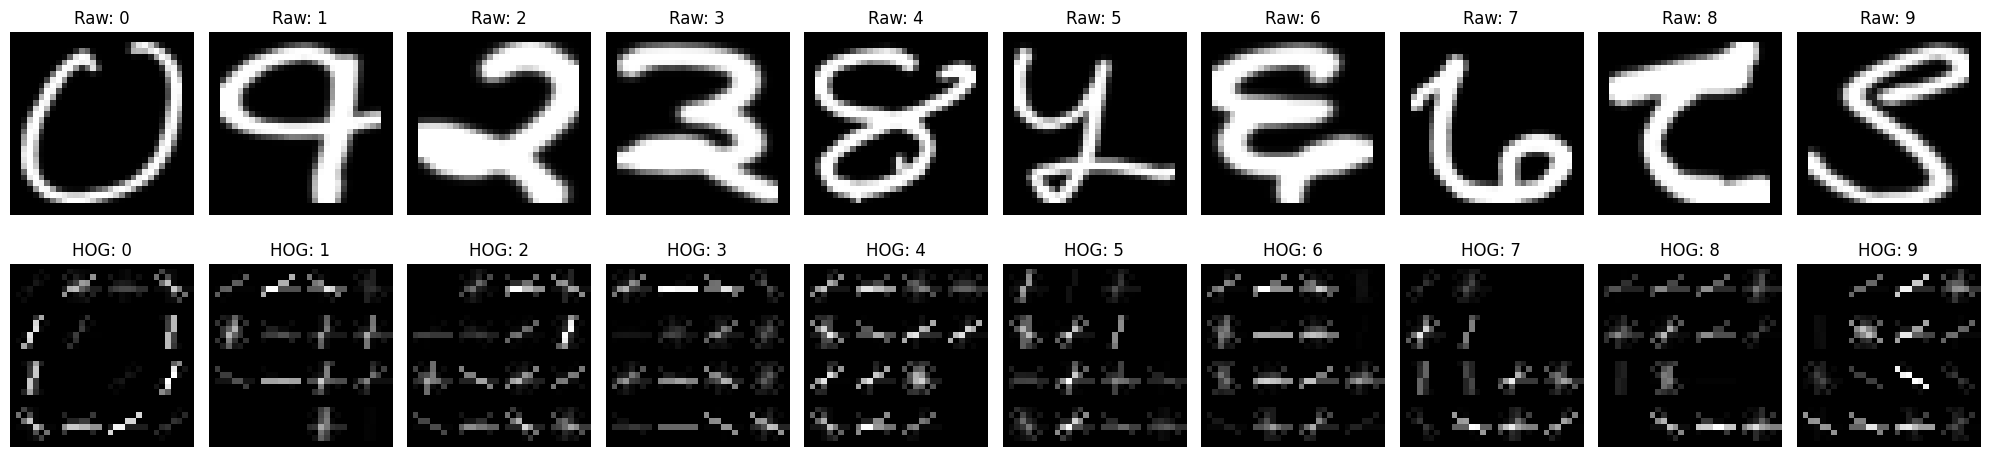

In [4]:
# Visualize 1 example per class from training set
import random
fig, axes = plt.subplots(2, 10, figsize=(20, 5))
shown = set()
count = 0

for i, img in enumerate(X_train_raw):
    label = y_train[i]
    if label not in shown:
        hog_img = hog(img, visualize=True, **hog_params)[1]
        axes[0, count].imshow(img, cmap='gray')
        axes[0, count].set_title(f"Raw: {label}")
        axes[0, count].axis('off')

        axes[1, count].imshow(hog_img, cmap='gray')
        axes[1, count].set_title(f"HOG: {label}")
        axes[1, count].axis('off')

        shown.add(label)
        count += 1
    if count >= 10:
        break

plt.tight_layout()
plt.show()


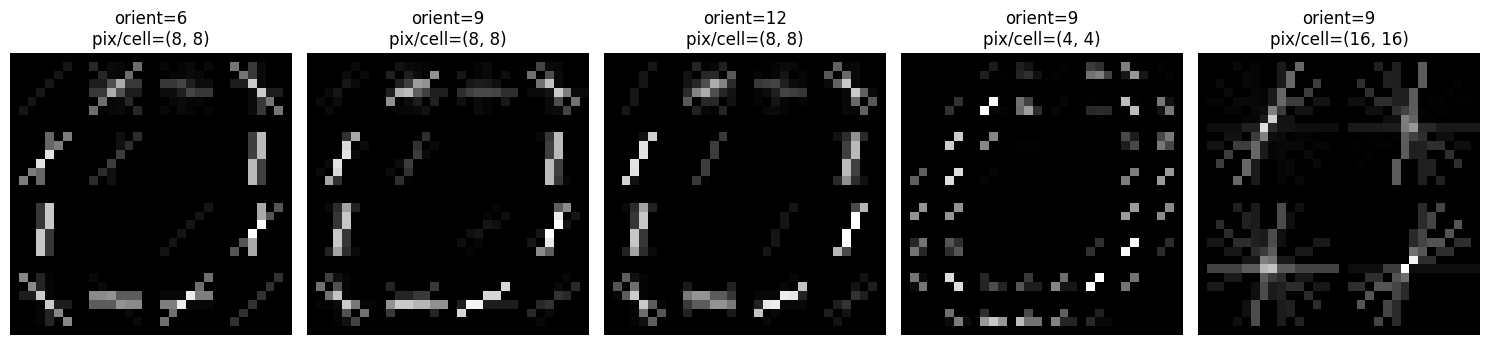

In [5]:
import matplotlib.pyplot as plt
from skimage.feature import hog
import cv2

# Load a sample image from your train set
sample_img = X_train_raw[0]  # already resized to 32x32 grayscale

# Try different HOG configs
hog_configs = [
    {"orientations": 6, "pixels_per_cell": (8, 8), "cells_per_block": (2, 2), "block_norm": 'L2-Hys'},
    {"orientations": 9, "pixels_per_cell": (8, 8), "cells_per_block": (2, 2), "block_norm": 'L2-Hys'},
    {"orientations": 12, "pixels_per_cell": (8, 8), "cells_per_block": (2, 2), "block_norm": 'L2-Hys'},
    {"orientations": 9, "pixels_per_cell": (4, 4), "cells_per_block": (2, 2), "block_norm": 'L2-Hys'},
    {"orientations": 9, "pixels_per_cell": (16, 16), "cells_per_block": (1, 1), "block_norm": 'L2-Hys'},
]

# Visualize
plt.figure(figsize=(15, 6))
for i, config in enumerate(hog_configs):
    features, hog_image = hog(sample_img, visualize=True, **config)
    plt.subplot(1, len(hog_configs), i+1)
    plt.imshow(hog_image, cmap='gray')
    plt.title(f"orient={config['orientations']}\npix/cell={config['pixels_per_cell']}")
    plt.axis('off')

plt.tight_layout()
plt.show()


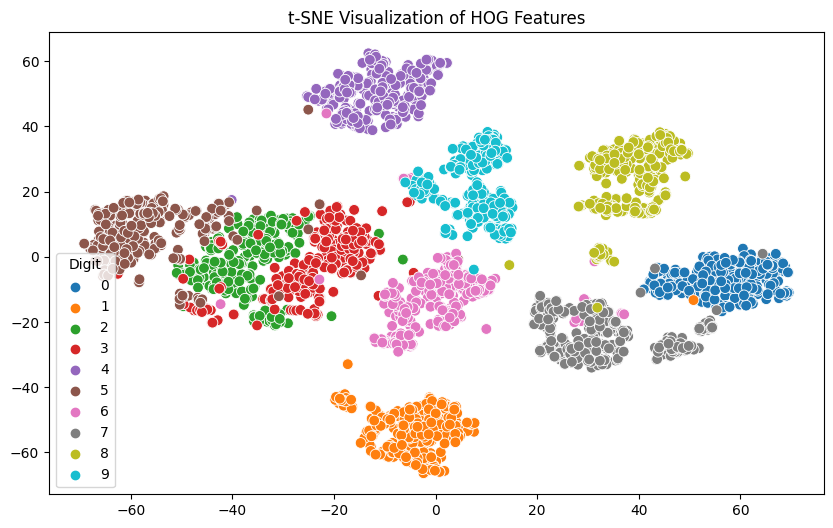

In [62]:
from sklearn.manifold import TSNE
import seaborn as sns
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_vis = tsne.fit_transform(X_test_hog[:3000])  # limit for speed
y_vis = y_test[:3000]

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_vis[:, 0], y=X_vis[:, 1], hue=y_vis, palette='tab10', s=60)
plt.title("t-SNE Visualization of HOG Features")
plt.legend(title='Digit')
plt.show()


In [76]:
svm = SVC(kernel='linear', gamma='scale')
svm.fit(X_train_hog, y_train)


SVC(kernel='linear')

In [12]:
total_images = 0

print("📊 Test Set Image Count per Class:\n")

for label in sorted(os.listdir(test_dir)):
    class_path = os.path.join(test_dir, label)
    count = len(os.listdir(class_path))
    total_images += count
    print(f"Class {label} → {count} images")

print(f"\n✅ Total Test Images: {total_images}")

📊 Test Set Image Count per Class:

Class digit_0 → 300 images
Class digit_1 → 300 images
Class digit_2 → 300 images
Class digit_3 → 300 images
Class digit_4 → 300 images
Class digit_5 → 300 images
Class digit_6 → 300 images
Class digit_7 → 300 images
Class digit_8 → 300 images
Class digit_9 → 300 images

✅ Total Test Images: 3000


In [77]:
y_pred = svm.predict(X_test_hog)

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))



Test Accuracy: 0.9906666666666667
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       300
           1       0.99      1.00      1.00       300
           2       0.97      0.98      0.98       300
           3       0.97      0.97      0.97       300
           4       0.99      1.00      0.99       300
           5       1.00      0.99      0.99       300
           6       0.99      0.98      0.99       300
           7       1.00      1.00      1.00       300
           8       1.00      1.00      1.00       300
           9       1.00      0.99      0.99       300

    accuracy                           0.99      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       0.99      0.99      0.99      3000



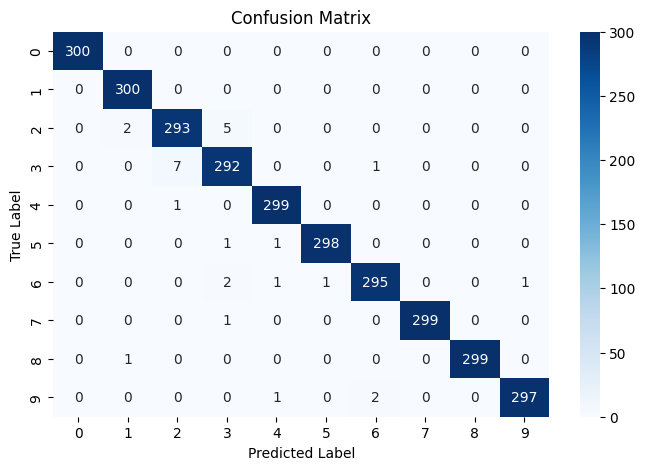

In [78]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(10), yticklabels=range(10), cbar=True)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [69]:
knn = KNeighborsClassifier(n_neighbors=5, metric='manhattan',p=2)
knn.fit(X_train_hog, y_train)

KNeighborsClassifier(metric='manhattan')

In [70]:
y_pred_knn = knn.predict(X_test_hog)

print("Test Accuracy:", accuracy_score(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn))

Test Accuracy: 0.983
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       300
           1       0.99      1.00      0.99       300
           2       0.94      0.98      0.96       300
           3       0.97      0.96      0.96       300
           4       0.99      1.00      1.00       300
           5       1.00      0.96      0.98       300
           6       0.99      0.97      0.98       300
           7       0.99      0.98      0.98       300
           8       1.00      0.99      0.99       300
           9       0.99      1.00      0.99       300

    accuracy                           0.98      3000
   macro avg       0.98      0.98      0.98      3000
weighted avg       0.98      0.98      0.98      3000



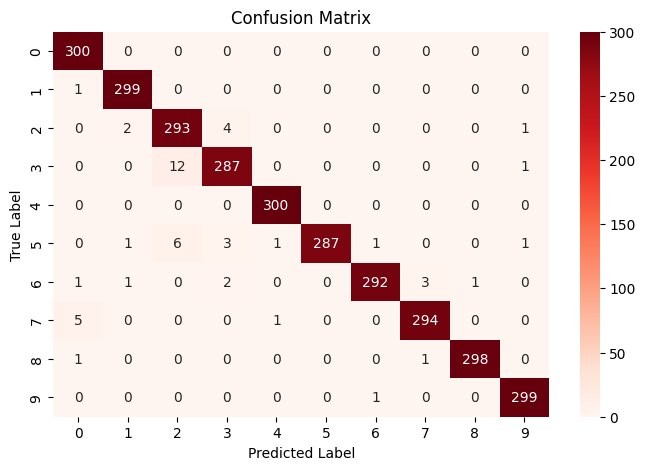

In [72]:
cm = confusion_matrix(y_test, y_pred_knn)
plt.figure(figsize=(8, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', 
            xticklabels=range(10), yticklabels=range(10), cbar=True)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [73]:
knn = KNeighborsClassifier(n_neighbors=1, metric='euclidean',p=5)
knn.fit(X_train_hog, y_train)

KNeighborsClassifier(metric='euclidean', n_neighbors=1, p=5)

In [74]:
y_pred_knn = knn.predict(X_test_hog)

print("Test Accuracy:", accuracy_score(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn))

Test Accuracy: 0.9946666666666667
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       300
           1       1.00      1.00      1.00       300
           2       0.99      0.99      0.99       300
           3       0.98      0.98      0.98       300
           4       1.00      1.00      1.00       300
           5       0.99      0.99      0.99       300
           6       1.00      0.99      0.99       300
           7       1.00      1.00      1.00       300
           8       1.00      1.00      1.00       300
           9       1.00      1.00      1.00       300

    accuracy                           0.99      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       0.99      0.99      0.99      3000



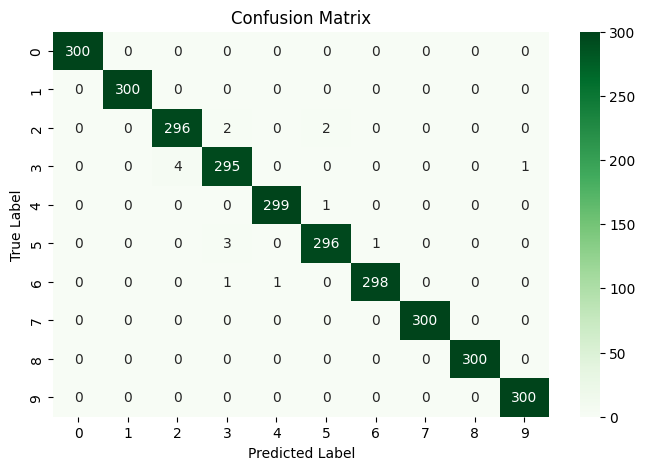

In [75]:
cm = confusion_matrix(y_test, y_pred_knn)
plt.figure(figsize=(8, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=range(10), yticklabels=range(10), cbar=True)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [79]:
from joblib import dump

# Save models
dump(svm, 'svm_model.joblib')
dump(knn, 'knn_model.joblib')


['knn_model.joblib']

In [80]:
dump(svm, 'svm_model.joblib')

['svm_model.joblib']